### What is the relationship between the average price of gasoline and the cost of electricity per kilowatt-hour, what model(s) can be used to make accurate predictions of future gas prices?

### Setup

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load datasets
gasoline_data_path = 'gasoline_data.csv'
electric_data_path = 'electric_data.csv'

gasoline_data = pd.read_csv(gasoline_data_path)
electric_data = pd.read_csv(electric_data_path)

### Data Cleansing

In [49]:
# split into proper columns
gasoline_data_clean = gasoline_data['series_id        \tyear\tperiod\t       value\tfootnote_codes'].str.split('\t', expand=True)
electric_data_clean = electric_data['series_id        \tyear\tperiod\t       value\tfootnote_codes'].str.split('\t', expand=True)

# rename columns
gasoline_columns = ['Series ID', 'Year', 'Period', 'Gasoline Price', 'Footnote Codes']
electric_columns = ['Series ID', 'Year', 'Period', 'Electricity Price', 'Footnote Codes']

gasoline_data_clean.columns = gasoline_columns
electric_data_clean.columns = electric_columns

# remove whitespace
gasoline_data_clean = gasoline_data_clean.apply(lambda x: x.str.strip())
electric_data_clean = electric_data_clean.apply(lambda x: x.str.strip())

# handle '-' entries
gasoline_data_clean['Gasoline Price'] = pd.to_numeric(gasoline_data_clean['Gasoline Price'], errors='coerce')
electric_data_clean['Electricity Price'] = pd.to_numeric(electric_data_clean['Electricity Price'], errors='coerce')

# check missing values
gasoline_missing = gasoline_data_clean.isnull().sum()
electric_missing = electric_data_clean.isnull().sum()

# display count of missing values (0 means none)
gasoline_missing, electric_missing

(Series ID         0
 Year              0
 Period            0
 Gasoline Price    0
 Footnote Codes    0
 dtype: int64,
 Series ID            0
 Year                 0
 Period               0
 Electricity Price    6
 Footnote Codes       0
 dtype: int64)

### Exploratory Analysis

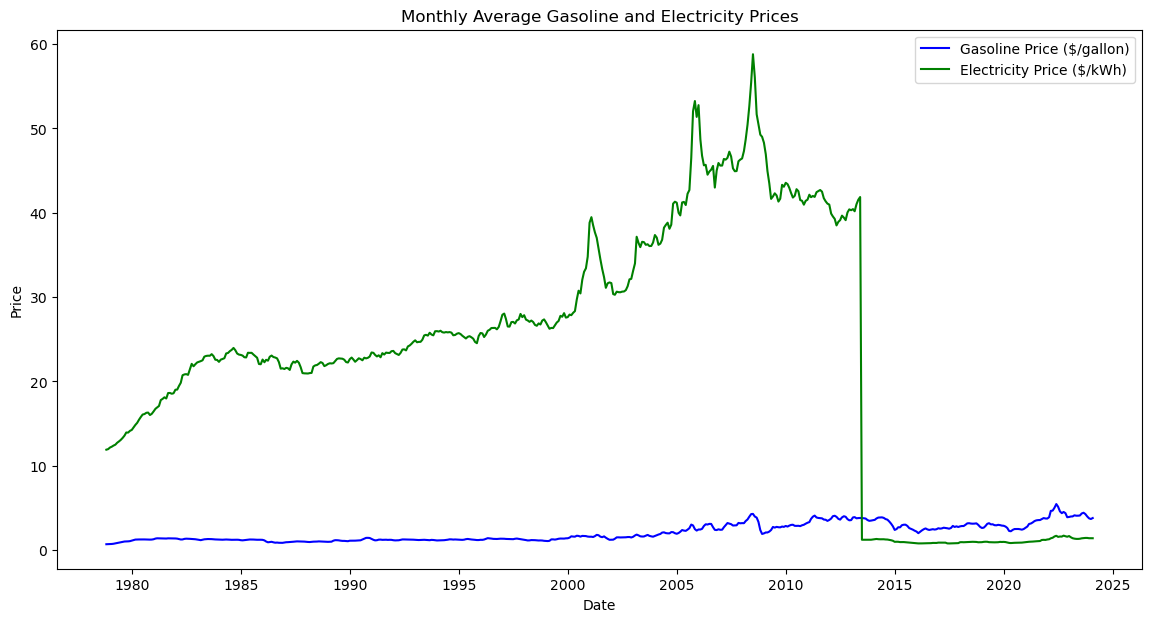

(       Gasoline Price
 count    92994.000000
 mean         2.059602
 std          1.108171
 min          0.402000
 25%          1.194000
 50%          1.503000
 75%          2.909000
 max          6.819000,
        Electricity Price
 count      105270.000000
 mean           24.909902
 std            32.031642
 min             0.000000
 25%             0.566000
 50%             2.089500
 75%            45.157000
 max           224.187000)

In [50]:
# basic stats for both datasets
gasoline_stats = gasoline_data_clean.describe()
electric_stats = electric_data_clean.describe()

# period to months
gasoline_data_clean['Month'] = gasoline_data_clean['Period'].str.replace('M', '').astype(int)
electric_data_clean['Month'] = electric_data_clean['Period'].str.replace('M', '').astype(int)
gasoline_data_clean['Date'] = pd.to_datetime(gasoline_data_clean[['Year', 'Month']].assign(DAY=1))
electric_data_clean['Date'] = pd.to_datetime(electric_data_clean[['Year', 'Month']].assign(DAY=1))

# Since the granularity is monthly, we'll average monthly prices for a direct comparison
gasoline_monthly_avg = gasoline_data_clean.groupby('Date')['Gasoline Price'].mean().reset_index()
electric_monthly_avg = electric_data_clean.groupby('Date')['Electricity Price'].mean().reset_index()

# merge
merged_data = pd.merge(gasoline_monthly_avg, electric_monthly_avg, on='Date', how='inner')

# plot
plt.figure(figsize=(14, 7))
plt.plot(merged_data['Date'], merged_data['Gasoline Price'], label='Gasoline Price ($/gallon)', color='blue')
plt.plot(merged_data['Date'], merged_data['Electricity Price'], label='Electricity Price ($/kWh)', color='green')
plt.title('Monthly Average Gasoline and Electricity Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

gasoline_stats, electric_stats

### Working with straightforward data (time and price), dimensionality reduction might not add value. More well-suited for datasets with large amounts of features

### Going to need more features for a more robust model. Adding some more features: (WTI Crude Oil Historical Data, 

In [51]:
# processing crude oil data for merged_data
wti_data = pd.read_csv('wti-crudeoil.csv', names=['Date', 'WTI Oil Price'], header=0)
wti_data['Date'] = pd.to_datetime(wti_data['Date'])
wti_data['Year'] = wti_data['Date'].dt.year
wti_data['Month'] = wti_data['Date'].dt.month
wti_monthly_avg = wti_data.groupby(['Year', 'Month'])['WTI Oil Price'].mean().reset_index()
wti_monthly_avg['Date'] = pd.to_datetime(wti_monthly_avg[['Year', 'Month']].assign(Day=1))
wti_monthly_avg = wti_monthly_avg[['Date', 'WTI Oil Price']]
merged_data = pd.merge(merged_data, wti_monthly_avg, on='Date', how='left')

# processing unemployment data for merged_data
unemployment_data = pd.read_csv('unemployment.csv', names=['Date', 'Unemployment Rate'], header=0)
unemployment_data['Date'] = pd.to_datetime(unemployment_data['Date'])
unemployment_data['Year'] = unemployment_data['Date'].dt.year
unemployment_data['Month'] = unemployment_data['Date'].dt.month
unemployment_data['Date'] = pd.to_datetime(unemployment_data[['Year', 'Month']].assign(Day=1))
unemployment_data = unemployment_data[['Date', 'Unemployment Rate']]
merged_data = pd.merge(merged_data, unemployment_data, on='Date', how='left')

# Check for missing values
print(merged_data.isnull().sum())

# Impute missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

X = merged_data[['Electricity Price', 'WTI Oil Price', 'Unemployment Rate']]
X_imputed = imputer.fit_transform(X)

X = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

y = merged_data['Gasoline Price']

# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit a linear regression model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

# Examine model coefficients
coef_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coef_df)

Date                   0
Gasoline Price         0
Electricity Price      0
WTI Oil Price         85
Unemployment Rate    253
dtype: int64
Root Mean Squared Error: 0.54
R-squared: 0.72
                   Coefficient
Electricity Price    -0.140251
WTI Oil Price         0.942485
Unemployment Rate    -0.007727


## Linear Regression Model

In [57]:
# Fit a linear regression model
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

y_pred = lr_model.predict(X_test_scaled)

# Evaluate the linear regression model
lr_y_pred = lr_model.predict(X_test_scaled)

lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, lr_y_pred)

print("Linear Regression Model:")
print(f"Root Mean Squared Error: {lr_rmse:.2f}")
print(f"R-squared: {lr_r2:.2f}")

# Examine linear regression model coefficients
lr_coef_df = pd.DataFrame(lr_model.coef_, X.columns, columns=['Coefficient'])
print("\nLinear Regression Model Coefficients:")
print(lr_coef_df)

Linear Regression Model:
Root Mean Squared Error: 0.54
R-squared: 0.72

Linear Regression Model Coefficients:
                   Coefficient
Electricity Price    -0.140251
WTI Oil Price         0.942485
Unemployment Rate    -0.007727


## K-Nearest Neighbors Model

In [62]:
# Fit a KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# Evaluate the KNN model
knn_y_pred = knn_model.predict(X_test_scaled)

knn_mse = mean_squared_error(y_test, knn_y_pred)
knn_rmse = np.sqrt(knn_mse)
knn_r2 = r2_score(y_test, knn_y_pred)

print("\nKNN Model:")
print(f"Root Mean Squared Error: {knn_rmse:.2f}")
print(f"R-squared: {knn_r2:.2f}")


KNN Model:
Root Mean Squared Error: 0.19
R-squared: 0.97


In [55]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score